# Computation in superposition
The goal of this notebook is to explore, how computation in superposition works. This is inspired by the paper [Mathematical Models of Computation in Superposition](https://arxiv.org/abs/2408.05451).

According to the paper, a one layer MLP with ReLU activations is able to compute the Universal AND (UAND) of binary features in superposition. We do experiments to see if the model actually learns this:

1. Naive Computation of UAND
2. Computation of UAND in superposition for basis-aligned features
3. Computation of UAND in superposition for not basis-aligned features

## Notation
We consider a fully-connected Neural Network $M:X \rightarrow Y$ with $L$ layers and ReLU activation functions. Let $x$ be the input of the MLP and let $d$ be the dimension of the hidden layers. We denote by $m$ the number of features.

For $k \in \{1,...,m \}$ we call a function $f_k:X \rightarrow \{0,1\}$ a boolean feature. A common assumption is that features are represented as directions in the activation space, i.e. that the activation of a given layer is given by $a(x) = \sum_i v_i f_i(x)$, where $v_1,...,v_m \in \mathbb R^d$ are called feature vectors. We call these basis aligned, if they correspond to the coordinate directions. A NN can (noisily) represent more feaures than it has dimensions ($m>d$) by choosing almost orthohonal feature vectors [Toy Models of Superposition](https://arxiv.org/abs/2209.10652).

Let $b \in \{ 0,1\}^m$ be a boolean vector. The UAND of b has $m \choose 2$ outputs, where each output is the AND of one of the ordered pairs.



## 1. Naive computation of UAND
For two boolean variables $x_1,x_2$, we can calculate their AND via $x_1 \wedge x_2 = ReLU(x_1+ x_2 -1)$. We can create a one-layer NN, with $m$ dimensional input and $m \choose 2$ neurons, that are taking the AND of two inputs. This Implements the UAND, where the activation of the output gives us a basis aligned and of the input features.

In [215]:
import torch
import einops
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import tqdm.auto as tqdm

In [281]:
class MLP(nn.Module):
    def __init__(self, d_in, d_hidden):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(d_hidden, d_in) / np.sqrt(d_in))
        self.b_in = nn.Parameter(torch.randn(d_hidden)/np.sqrt(d_hidden))
        #self.b_in = nn.Parameter(torch.zeros(d_hidden))

    def forward(self, x):           # x shape: (d_in, batch)
        x = torch.einsum('dm, bm -> b d', self.W_in, x)  # (d_hidden, batch)
        x = x + self.b_in[None,:]                      # broadcast bias
        return F.relu(x)

In [282]:
# Setup
m = 20
d = int(m*(m-1)/2)
#batch_size = 10000
train_frac = 0.4
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

print(f"Using {device} device")
print(d)

Using mps device
190


In [283]:
# For fixed m, there are 2^m possible boolean vectors and we 
dataset_size = 2**m
def all_boolean_vectors(m: int, msb_first: bool = True) -> torch.Tensor:
    """
    Returns a uint8 tensor of shape (2**m, m) with entries 0/1.
    If msb_first is True, column 0 is the most significant bit.
    """
    n = 2**m  # 2**m
    # numbers: [0, 1, 2, ..., 2**m - 1]
    numbers = torch.arange(n, dtype=torch.long)
    bit_positions = torch.arange(m, dtype=torch.long)  # 0..m-1 (LSB..MSB)
    bits = ((numbers[:, None] >> bit_positions) & 1).to(torch.uint8)  # (n, m), LSB-first
    if msb_first:
        bits = bits.flip(dims=[1])  # make column 0 the MSB
    return bits
bool_vecs = all_boolean_vectors(m,True)
# next, we calculate the corresponding labels:

output_size = int(m*(m-1)/2)
out_vecs = torch.zeros(size=(dataset_size,output_size))

idx_i, idx_j = torch.triu_indices(m, m, offset=1)  # all pairs i<j

out_vecs = (bool_vecs[:, idx_i] & bool_vecs[:, idx_j]).float()
""" Randomly creating a dataset of boolean vecs:
bool_vecs = torch.randint(low = 0,high = 2, size = (m,batch_size))

output_size  = int(m*(m-1)/2)
out_vec = torch.zeros(size = (output_size,batch_size))

"""
#Randomly permute the dataset
indices = torch.randperm(dataset_size)
train_indices = indices[:int(train_frac*dataset_size)]
test_indices = indices[int(train_frac*dataset_size):]

#Split into train and test data
train_data = bool_vecs[train_indices].to(torch.float32).to(device=device)
train_labels = out_vecs[train_indices].to(torch.float32).to(device=device)
test_data = bool_vecs[test_indices].to(torch.float32).to(device=device)
test_labels = out_vecs[test_indices].to(torch.float32).to(device=device)

print(train_data.shape)
print(train_labels.shape)
print(m*(m-1)/2)




torch.Size([419430, 20])
torch.Size([419430, 190])
190.0


In [284]:
print(train_data[1])
print(train_labels[1])

tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
        1., 1.], device='mps:0')
tensor([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='mps:0')


In [285]:
one_layer_mlp = MLP(m,d).to(device=device)
one_layer_mlp(train_data)
one_layer_mlp.b_in

Parameter containing:
tensor([-0.0121, -0.0413,  0.0112, -0.0378, -0.1096,  0.0057, -0.0584,  0.0534,
         0.0086, -0.0893, -0.0698,  0.0527, -0.0095, -0.0437, -0.0828,  0.0431,
        -0.0204,  0.0262, -0.0160,  0.0853, -0.1124,  0.0120, -0.0829, -0.0381,
        -0.0730,  0.1629, -0.1292, -0.0444, -0.1596, -0.0418,  0.0024, -0.0065,
        -0.0138, -0.0457, -0.0611, -0.0554,  0.1283, -0.0520, -0.0761, -0.0056,
         0.1165, -0.0129, -0.0557,  0.0794,  0.0632, -0.0721, -0.0486, -0.0341,
        -0.0974, -0.0487, -0.0200,  0.0247, -0.1011, -0.0890, -0.0095, -0.1211,
         0.0508, -0.0440, -0.0053, -0.2064,  0.0153,  0.0101, -0.0299, -0.0826,
         0.1644, -0.1512,  0.1448, -0.1114,  0.0342, -0.1214,  0.0322, -0.0088,
         0.0002, -0.0290,  0.0279,  0.0060, -0.0475,  0.0647, -0.0723, -0.0006,
        -0.0222, -0.0227, -0.0085,  0.0144, -0.0205,  0.0304,  0.0622, -0.0861,
         0.0190, -0.0011,  0.1201, -0.0606, -0.0118,  0.0737,  0.1569,  0.0235,
         0.0186, -

In [286]:
#training parameters
n_epoch = 10000
lr = 1e-3
wd = 1e-5
DATA_SEED = 234
betas = (0.8,0.98)



In [287]:
# Define optimizer
optimizer = torch.optim.AdamW(one_layer_mlp.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [288]:
#Define loss
def loss_fn(pred, target):
    """
    pred   : Tensor of arbitrary shape
    target : same shape as pred
    returns: scalar mean((pred - target)^2)
    """
    return abs(pred - target).mean()


pred = one_layer_mlp(train_data)
print(pred.shape)
print(train_labels.shape)
loss2 = loss_fn(pred, train_labels)
print(loss_fn(one_layer_mlp(train_data),train_labels))


torch.Size([419430, 190])
torch.Size([419430, 190])
tensor(0.3938, device='mps:0', grad_fn=<MeanBackward0>)


In [289]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_pred = one_layer_mlp(train_data)
    train_loss = loss_fn(train_pred,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    with torch.inference_mode():
        test_pred = one_layer_mlp(test_data)
        test_loss = loss_fn(test_pred,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  1%|          | 101/10000 [00:10<15:36, 10.58it/s]

Epoch 99 Train Loss 0.26615095138549805 Test loss 0.26558077335357666


  2%|▏         | 201/10000 [00:20<15:15, 10.70it/s]

Epoch 199 Train Loss 0.2429385930299759 Test loss 0.24261924624443054


  3%|▎         | 301/10000 [00:29<14:49, 10.90it/s]

Epoch 299 Train Loss 0.22741515934467316 Test loss 0.2271125316619873


  4%|▍         | 401/10000 [00:39<14:41, 10.89it/s]

Epoch 399 Train Loss 0.21117641031742096 Test loss 0.21088047325611115


  5%|▌         | 502/10000 [00:49<15:48, 10.01it/s]

Epoch 499 Train Loss 0.19611875712871552 Test loss 0.1958369016647339


  6%|▌         | 600/10000 [00:58<14:14, 11.00it/s]

Epoch 599 Train Loss 0.18225015699863434 Test loss 0.18198920786380768


  7%|▋         | 701/10000 [01:08<14:01, 11.05it/s]

Epoch 699 Train Loss 0.16974592208862305 Test loss 0.169510617852211


  8%|▊         | 801/10000 [01:17<13:47, 11.11it/s]

Epoch 799 Train Loss 0.15920346975326538 Test loss 0.15898847579956055


  9%|▉         | 902/10000 [01:26<13:40, 11.09it/s]

Epoch 899 Train Loss 0.15086136758327484 Test loss 0.1506647765636444


 10%|█         | 1001/10000 [01:35<15:29,  9.68it/s]

Epoch 999 Train Loss 0.14450253546237946 Test loss 0.14433038234710693


 11%|█         | 1101/10000 [01:45<13:24, 11.07it/s]

Epoch 1099 Train Loss 0.1401718705892563 Test loss 0.13999828696250916


 12%|█▏        | 1201/10000 [01:54<13:42, 10.69it/s]

Epoch 1199 Train Loss 0.13735225796699524 Test loss 0.13719606399536133


 13%|█▎        | 1301/10000 [02:04<13:15, 10.94it/s]

Epoch 1299 Train Loss 0.13571050763130188 Test loss 0.13557161390781403


 14%|█▍        | 1402/10000 [02:13<12:56, 11.07it/s]

Epoch 1399 Train Loss 0.1350061595439911 Test loss 0.13487698137760162


 15%|█▌        | 1502/10000 [02:22<12:43, 11.13it/s]

Epoch 1499 Train Loss 0.1346840262413025 Test loss 0.13454395532608032


 16%|█▌        | 1602/10000 [02:31<12:38, 11.08it/s]

Epoch 1599 Train Loss 0.1345387101173401 Test loss 0.13440142571926117


 17%|█▋        | 1702/10000 [02:41<12:56, 10.68it/s]

Epoch 1699 Train Loss 0.1344754844903946 Test loss 0.13433341681957245


 18%|█▊        | 1802/10000 [02:50<12:35, 10.85it/s]

Epoch 1799 Train Loss 0.13443852961063385 Test loss 0.13430482149124146


 19%|█▉        | 1902/10000 [02:59<12:20, 10.93it/s]

Epoch 1899 Train Loss 0.13442286849021912 Test loss 0.1342833936214447


 20%|██        | 2002/10000 [03:08<12:10, 10.94it/s]

Epoch 1999 Train Loss 0.1344236433506012 Test loss 0.1342795491218567


 21%|██        | 2102/10000 [03:17<11:59, 10.98it/s]

Epoch 2099 Train Loss 0.13442064821720123 Test loss 0.1342853158712387


 22%|██▏       | 2201/10000 [03:27<12:04, 10.77it/s]

Epoch 2199 Train Loss 0.1344226449728012 Test loss 0.13428311049938202


 23%|██▎       | 2301/10000 [03:36<11:50, 10.84it/s]

Epoch 2299 Train Loss 0.13442391157150269 Test loss 0.13427941501140594


 24%|██▍       | 2401/10000 [03:45<11:41, 10.83it/s]

Epoch 2399 Train Loss 0.1344207525253296 Test loss 0.13428546488285065


 25%|██▌       | 2501/10000 [03:54<11:37, 10.75it/s]

Epoch 2499 Train Loss 0.13442255556583405 Test loss 0.13428273797035217


 26%|██▌       | 2601/10000 [04:04<11:18, 10.90it/s]

Epoch 2599 Train Loss 0.13442407548427582 Test loss 0.13427916169166565


 27%|██▋       | 2701/10000 [04:13<11:09, 10.91it/s]

Epoch 2699 Train Loss 0.1344209760427475 Test loss 0.13428516685962677


 28%|██▊       | 2801/10000 [04:22<10:54, 10.99it/s]

Epoch 2799 Train Loss 0.13442277908325195 Test loss 0.13428257405757904


 29%|██▉       | 2901/10000 [04:31<10:44, 11.02it/s]

Epoch 2899 Train Loss 0.13442425429821014 Test loss 0.1342790573835373


 30%|███       | 3001/10000 [04:41<10:40, 10.93it/s]

Epoch 2999 Train Loss 0.13442111015319824 Test loss 0.1342850774526596


 31%|███       | 3101/10000 [04:50<10:26, 11.01it/s]

Epoch 3099 Train Loss 0.13442285358905792 Test loss 0.13428246974945068


 32%|███▏      | 3201/10000 [05:00<11:14, 10.08it/s]

Epoch 3199 Train Loss 0.13442428410053253 Test loss 0.13427893817424774


 33%|███▎      | 3301/10000 [05:09<10:08, 11.00it/s]

Epoch 3299 Train Loss 0.13442108035087585 Test loss 0.13428501784801483


 34%|███▍      | 3402/10000 [05:19<10:00, 10.98it/s]

Epoch 3399 Train Loss 0.13442280888557434 Test loss 0.1342824548482895


 35%|███▌      | 3502/10000 [05:28<09:53, 10.94it/s]

Epoch 3499 Train Loss 0.13442423939704895 Test loss 0.1342790126800537


 36%|███▌      | 3602/10000 [05:37<09:41, 10.99it/s]

Epoch 3599 Train Loss 0.13442103564739227 Test loss 0.1342850774526596


 37%|███▋      | 3702/10000 [05:46<09:34, 10.96it/s]

Epoch 3699 Train Loss 0.13442279398441315 Test loss 0.13428248465061188


 38%|███▊      | 3802/10000 [05:56<09:22, 11.01it/s]

Epoch 3799 Train Loss 0.13442425429821014 Test loss 0.1342790275812149


 39%|███▉      | 3902/10000 [06:05<09:14, 11.00it/s]

Epoch 3899 Train Loss 0.13442102074623108 Test loss 0.134285107254982


 40%|████      | 4002/10000 [06:14<09:05, 11.00it/s]

Epoch 3999 Train Loss 0.13442277908325195 Test loss 0.13428246974945068


 41%|████      | 4102/10000 [06:24<08:54, 11.03it/s]

Epoch 4099 Train Loss 0.13442425429821014 Test loss 0.1342790424823761


 42%|████▏     | 4202/10000 [06:33<08:48, 10.97it/s]

Epoch 4199 Train Loss 0.13442100584506989 Test loss 0.1342851221561432


 43%|████▎     | 4301/10000 [06:42<08:37, 11.02it/s]

Epoch 4299 Train Loss 0.13442276418209076 Test loss 0.13428246974945068


 44%|████▍     | 4401/10000 [06:51<08:31, 10.95it/s]

Epoch 4399 Train Loss 0.13442425429821014 Test loss 0.1342790573835373


 45%|████▌     | 4501/10000 [07:00<08:20, 10.99it/s]

Epoch 4499 Train Loss 0.1344209760427475 Test loss 0.13428513705730438


 46%|████▌     | 4602/10000 [07:10<09:00,  9.99it/s]

Epoch 4599 Train Loss 0.13442273437976837 Test loss 0.13428246974945068


 47%|████▋     | 4702/10000 [07:20<08:01, 11.01it/s]

Epoch 4699 Train Loss 0.13442425429821014 Test loss 0.1342790722846985


 48%|████▊     | 4802/10000 [07:29<07:53, 10.98it/s]

Epoch 4799 Train Loss 0.1344209760427475 Test loss 0.13428513705730438


 49%|████▉     | 4902/10000 [07:38<07:43, 11.01it/s]

Epoch 4899 Train Loss 0.13442273437976837 Test loss 0.13428248465061188


 50%|█████     | 5002/10000 [07:47<07:35, 10.98it/s]

Epoch 4999 Train Loss 0.13442425429821014 Test loss 0.13427908718585968


 51%|█████     | 5102/10000 [07:56<07:34, 10.78it/s]

Epoch 5099 Train Loss 0.1344209611415863 Test loss 0.13428515195846558


 52%|█████▏    | 5202/10000 [08:05<07:16, 10.99it/s]

Epoch 5199 Train Loss 0.13442271947860718 Test loss 0.13428248465061188


 53%|█████▎    | 5302/10000 [08:14<07:09, 10.95it/s]

Epoch 5299 Train Loss 0.13442425429821014 Test loss 0.13427911698818207


 54%|█████▍    | 5402/10000 [08:24<06:58, 10.99it/s]

Epoch 5399 Train Loss 0.1344209611415863 Test loss 0.13428516685962677


 55%|█████▌    | 5502/10000 [08:33<06:50, 10.96it/s]

Epoch 5499 Train Loss 0.13442271947860718 Test loss 0.13428248465061188


 56%|█████▌    | 5602/10000 [08:42<06:39, 11.00it/s]

Epoch 5599 Train Loss 0.13442425429821014 Test loss 0.13427911698818207


 57%|█████▋    | 5702/10000 [08:51<06:30, 11.00it/s]

Epoch 5699 Train Loss 0.1344209611415863 Test loss 0.13428516685962677


 58%|█████▊    | 5802/10000 [09:01<06:24, 10.93it/s]

Epoch 5799 Train Loss 0.13442271947860718 Test loss 0.13428248465061188


 59%|█████▉    | 5902/10000 [09:10<06:11, 11.03it/s]

Epoch 5899 Train Loss 0.13442425429821014 Test loss 0.13427911698818207


 60%|██████    | 6002/10000 [09:19<06:02, 11.04it/s]

Epoch 5999 Train Loss 0.1344209611415863 Test loss 0.13428518176078796


 61%|██████    | 6102/10000 [09:28<05:53, 11.02it/s]

Epoch 6099 Train Loss 0.13442271947860718 Test loss 0.13428248465061188


 62%|██████▏   | 6202/10000 [09:37<05:44, 11.02it/s]

Epoch 6199 Train Loss 0.13442425429821014 Test loss 0.13427911698818207


 63%|██████▎   | 6302/10000 [09:46<05:35, 11.03it/s]

Epoch 6299 Train Loss 0.1344209611415863 Test loss 0.13428518176078796


 64%|██████▍   | 6402/10000 [09:56<05:26, 11.03it/s]

Epoch 6399 Train Loss 0.1344226896762848 Test loss 0.13428248465061188


 65%|██████▌   | 6502/10000 [10:05<05:23, 10.80it/s]

Epoch 6499 Train Loss 0.13442425429821014 Test loss 0.13427911698818207


 66%|██████▌   | 6602/10000 [10:14<05:08, 11.01it/s]

Epoch 6599 Train Loss 0.1344209611415863 Test loss 0.13428519666194916


 67%|██████▋   | 6701/10000 [10:24<05:05, 10.78it/s]

Epoch 6699 Train Loss 0.1344226896762848 Test loss 0.13428248465061188


 68%|██████▊   | 6801/10000 [10:33<04:50, 10.99it/s]

Epoch 6799 Train Loss 0.13442423939704895 Test loss 0.13427908718585968


 69%|██████▉   | 6901/10000 [10:42<04:40, 11.03it/s]

Epoch 6899 Train Loss 0.1344209611415863 Test loss 0.13428519666194916


 70%|███████   | 7001/10000 [10:51<04:31, 11.04it/s]

Epoch 6999 Train Loss 0.1344226896762848 Test loss 0.13428248465061188


 71%|███████   | 7101/10000 [11:00<04:23, 10.99it/s]

Epoch 7099 Train Loss 0.13442423939704895 Test loss 0.13427908718585968


 72%|███████▏  | 7201/10000 [11:09<04:13, 11.03it/s]

Epoch 7199 Train Loss 0.1344209611415863 Test loss 0.13428519666194916


 73%|███████▎  | 7301/10000 [11:18<04:04, 11.03it/s]

Epoch 7299 Train Loss 0.1344226598739624 Test loss 0.13428248465061188


 74%|███████▍  | 7401/10000 [11:28<03:58, 10.90it/s]

Epoch 7399 Train Loss 0.13442425429821014 Test loss 0.13427908718585968


 75%|███████▌  | 7501/10000 [11:37<03:46, 11.03it/s]

Epoch 7499 Train Loss 0.1344209611415863 Test loss 0.13428525626659393


 76%|███████▌  | 7601/10000 [11:46<03:37, 11.04it/s]

Epoch 7599 Train Loss 0.1344226449728012 Test loss 0.1342824548482895


 77%|███████▋  | 7701/10000 [11:55<03:28, 11.04it/s]

Epoch 7699 Train Loss 0.13442428410053253 Test loss 0.13427913188934326


 78%|███████▊  | 7802/10000 [12:04<03:38, 10.04it/s]

Epoch 7799 Train Loss 0.13442093133926392 Test loss 0.13428527116775513


 79%|███████▉  | 7902/10000 [12:14<03:11, 10.97it/s]

Epoch 7899 Train Loss 0.13442261517047882 Test loss 0.1342824548482895


 80%|████████  | 8002/10000 [12:23<03:02, 10.96it/s]

Epoch 7999 Train Loss 0.13442429900169373 Test loss 0.13427913188934326


 81%|████████  | 8102/10000 [12:32<02:52, 11.01it/s]

Epoch 8099 Train Loss 0.13442093133926392 Test loss 0.13428527116775513


 82%|████████▏ | 8202/10000 [12:41<02:43, 11.02it/s]

Epoch 8199 Train Loss 0.13442261517047882 Test loss 0.1342824548482895


 83%|████████▎ | 8302/10000 [12:50<02:35, 10.95it/s]

Epoch 8299 Train Loss 0.13442428410053253 Test loss 0.13427911698818207


 84%|████████▍ | 8402/10000 [12:59<02:25, 11.01it/s]

Epoch 8399 Train Loss 0.13442093133926392 Test loss 0.13428528606891632


 85%|████████▌ | 8501/10000 [13:09<02:16, 10.97it/s]

Epoch 8499 Train Loss 0.13442258536815643 Test loss 0.1342824548482895


 86%|████████▌ | 8601/10000 [13:18<02:07, 10.98it/s]

Epoch 8599 Train Loss 0.13442428410053253 Test loss 0.13427913188934326


 87%|████████▋ | 8701/10000 [13:27<01:58, 11.01it/s]

Epoch 8699 Train Loss 0.1344209611415863 Test loss 0.13428530097007751


 88%|████████▊ | 8801/10000 [13:36<01:50, 10.82it/s]

Epoch 8799 Train Loss 0.13442258536815643 Test loss 0.13428246974945068


 89%|████████▉ | 8902/10000 [13:46<01:49, 10.00it/s]

Epoch 8899 Train Loss 0.13442429900169373 Test loss 0.13427913188934326


 90%|█████████ | 9002/10000 [14:25<01:31, 10.96it/s]  

Epoch 8999 Train Loss 0.1344209611415863 Test loss 0.13428530097007751


 91%|█████████ | 9102/10000 [14:36<01:20, 11.09it/s]

Epoch 9099 Train Loss 0.13442258536815643 Test loss 0.1342824548482895


 92%|█████████▏| 9202/10000 [14:45<01:11, 11.10it/s]

Epoch 9199 Train Loss 0.13442428410053253 Test loss 0.13427911698818207


 93%|█████████▎| 9302/10000 [14:54<01:02, 11.11it/s]

Epoch 9299 Train Loss 0.1344209611415863 Test loss 0.1342853158712387


 94%|█████████▍| 9402/10000 [15:03<00:53, 11.18it/s]

Epoch 9399 Train Loss 0.13442255556583405 Test loss 0.13428246974945068


 95%|█████████▌| 9502/10000 [18:34<00:45, 11.04it/s]  

Epoch 9499 Train Loss 0.13442428410053253 Test loss 0.13427911698818207


 96%|█████████▌| 9601/10000 [18:45<00:35, 11.19it/s]

Epoch 9599 Train Loss 0.1344209611415863 Test loss 0.1342853307723999


 97%|█████████▋| 9701/10000 [18:54<00:26, 11.19it/s]

Epoch 9699 Train Loss 0.13442254066467285 Test loss 0.13428246974945068


 98%|█████████▊| 9801/10000 [19:03<00:17, 11.11it/s]

Epoch 9799 Train Loss 0.13442428410053253 Test loss 0.13427913188934326


 99%|█████████▉| 9901/10000 [19:12<00:08, 11.12it/s]

Epoch 9899 Train Loss 0.1344209611415863 Test loss 0.1342853456735611


100%|██████████| 10000/10000 [19:48<00:00,  8.41it/s]

Epoch 9999 Train Loss 0.13442254066467285 Test loss 0.13428246974945068


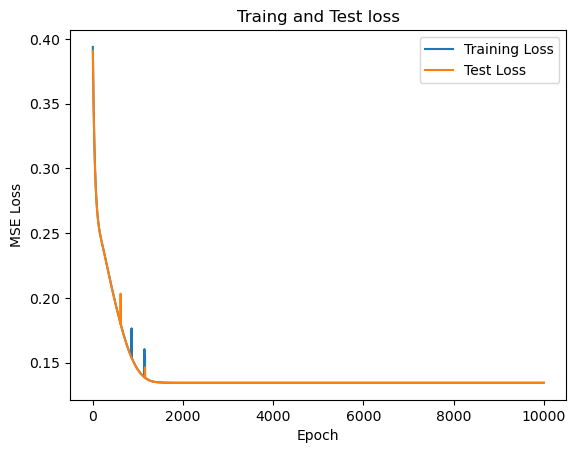

In [290]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()

### Looking at the learned parameters

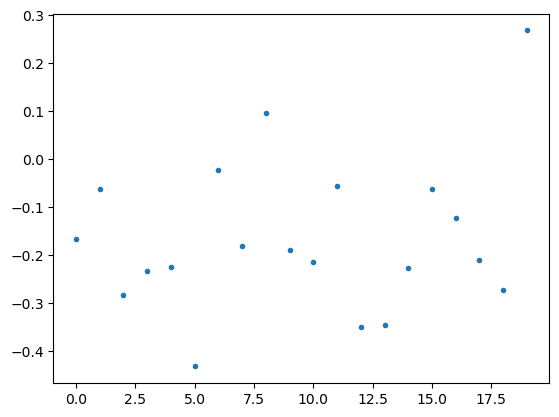

In [243]:
#print(one_layer_mlp.W_in[3])
#print(one_layer_mlp.b_in)
plt.plot(one_layer_mlp.W_in[2].cpu().detach().numpy(),".")

In [73]:
b = torch.zeros(size=(m,2))
b[0,:] = 1.
b[2,:] = 1.
b = b.to(device=device)

print(one_layer_mlp(b))

tensor([[0.0000, 0.0000],
        [0.9993, 0.9993],
        [0.0013, 0.0013],
        ...,
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


### Summary:
Perhaps not really surprisingly it looks like the MLP is roughly learning the expected behaviour, when given enough neurons. I am not really sure, why it does not learn perfect accuracy, probably because it does not see the whole dataset. But strangely, even if I train with the whole dataset, it is not getting perfectly accurate. I am not really sure, whether doing full batch training and the l_1 loss function is a good choice here. Since I draw the boolean vectors at random, there is no guarantee, that we actually have all possible combinations in the dataset.

## Computation of UAND in superposition for basis aligned features
The next (more interesting) step is to give the NN less neurons, than it needs for a naive implementation of UAND. In theory, it could learn to compute UAND in superposition. As a first step, we assume here that the boolean features are not in superposition and basis aligned, i.e. for $1\leq i \leq m:$ $x_i = 1$ if feature $i$ is present and $0$ otherwise. Furthermore, we assume that the features are $s$ -sparse, meaning that at most $s$ features are active for a given input $x$, i.e. $\sum_i x_i \leq s$.

In [121]:
m = 50 #number of input features
s= 5
epsilon = 0.1   #the error we tolerate

In [122]:
#network setup
#d = int((np.log(m))**8/epsilon**2)
d = int(1/epsilon**2 +1)
d_out = int(m*(m-1)/2)
print(d)
print(m*(m-1)/2)

100
1225.0


### Architecture
We also alter the architecture for the training process. We add a "read out" layer to give the MLP the possibility to calclulate the UAND in superposition

In [123]:
class MLP2(nn.Module):
    def __init__(self, d_in, d_hidden,d_out):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(d_hidden, d_in) / np.sqrt(d_in))
        self.b_in = nn.Parameter(torch.zeros(d_hidden))

        self.W_out = nn.Parameter(torch.randn(d_out, d_hidden) / np.sqrt(d_hidden))

    def forward(self, x):           # x shape: (d_in, batch)
        x = torch.einsum('hi, ib -> hb', self.W_in, x)  # (d_hidden, batch)
        x = x + self.b_in[:, None]                      # broadcast bias
        x = F.relu(x)
        x =  torch.einsum('oh, hb -> ob', self.W_out, x)  #(d_out, batch)
        return x

In [124]:
print("d_in: ")
print(m)
print("d_hidden: ")
print(d)
print("d_out:")
print(d_out)
mlp2 = MLP2(d_in=m,d_hidden=d,d_out=d_out).to(device=device)
print(mlp2(train_data))

d_in: 
50
d_hidden: 
100
d_out:
1225
tensor([[-0.2749, -0.7084, -0.5706,  ..., -0.8609, -0.5058, -0.7931],
        [ 0.2878,  0.3369,  0.2901,  ...,  0.1792,  0.2045, -0.0426],
        [ 0.0961, -0.0233, -0.0630,  ..., -0.0378, -0.7599, -0.0491],
        ...,
        [ 0.3277,  0.5979,  0.6914,  ...,  0.7134,  0.8463,  0.6345],
        [ 0.2983,  0.1552,  0.7305,  ...,  0.3838,  0.0233,  0.5147],
        [-0.6301, -0.4478, -0.3015,  ..., -0.3604, -0.2218, -0.2479]],
       device='mps:0', grad_fn=<ViewBackward0>)


In [125]:

#training parameters
n_epoch = 50000
lr = 1e-3
wd = 1e-1
DATA_SEED = 347
betas = (0.9,0.98)


In [126]:
# Define optimizer
optimizer2 = torch.optim.AdamW(mlp2.parameters(),lr=lr, betas=betas,weight_decay=wd)

In [127]:
train_losses = []
test_losses = []
for epoch in tqdm.tqdm(range(n_epoch)):
    train_pred = mlp2(train_data)
    train_loss = loss_fn(train_pred,train_labels)
    train_loss.backward()
    train_losses.append(train_loss.item())
    optimizer2.step()
    optimizer2.zero_grad()
    with torch.inference_mode():
        test_pred = mlp2(test_data)
        test_loss = loss_fn(test_pred,test_labels)
        test_losses.append(test_loss.item())

    if ((epoch+1)%100)==0:
        print(f"Epoch {epoch} Train Loss {train_loss.item()} Test loss {test_loss.item()}")

  0%|          | 116/50000 [00:01<08:47, 94.58it/s]

Epoch 99 Train Loss 0.25427159667015076 Test loss 0.25449836254119873


  0%|          | 215/50000 [00:02<09:26, 87.93it/s]

Epoch 199 Train Loss 0.25034794211387634 Test loss 0.2507229745388031


  1%|          | 314/50000 [00:03<09:03, 91.43it/s]

Epoch 299 Train Loss 0.2501377463340759 Test loss 0.25052475929260254


  1%|          | 415/50000 [00:04<09:14, 89.41it/s]

Epoch 399 Train Loss 0.2501089870929718 Test loss 0.25049692392349243


  1%|          | 513/50000 [00:05<10:02, 82.11it/s]

Epoch 499 Train Loss 0.2501075863838196 Test loss 0.2504899799823761


  1%|          | 612/50000 [00:06<09:17, 88.61it/s]

Epoch 599 Train Loss 0.2501074969768524 Test loss 0.2504846751689911


  1%|▏         | 714/50000 [00:07<08:27, 97.03it/s]

Epoch 699 Train Loss 0.2501068413257599 Test loss 0.2504822015762329


  2%|▏         | 816/50000 [00:09<09:21, 87.55it/s] 

Epoch 799 Train Loss 0.25010329484939575 Test loss 0.25047847628593445


  2%|▏         | 917/50000 [00:10<08:56, 91.48it/s]

Epoch 899 Train Loss 0.250094473361969 Test loss 0.25047436356544495


  2%|▏         | 1015/50000 [00:11<09:18, 87.73it/s]

Epoch 999 Train Loss 0.2500918209552765 Test loss 0.2504686713218689


  2%|▏         | 1107/50000 [00:12<08:42, 93.59it/s]

Epoch 1099 Train Loss 0.25009170174598694 Test loss 0.25046420097351074


  2%|▏         | 1214/50000 [00:13<09:23, 86.59it/s]

Epoch 1199 Train Loss 0.25009170174598694 Test loss 0.25045743584632874


  3%|▎         | 1316/50000 [00:14<09:13, 87.96it/s]

Epoch 1299 Train Loss 0.2500917315483093 Test loss 0.2504533529281616


  3%|▎         | 1415/50000 [00:15<09:12, 87.92it/s]

Epoch 1399 Train Loss 0.25009170174598694 Test loss 0.2504495680332184


  3%|▎         | 1517/50000 [00:16<08:37, 93.62it/s]

Epoch 1499 Train Loss 0.2500917315483093 Test loss 0.25044378638267517


  3%|▎         | 1611/50000 [00:17<08:40, 92.97it/s] 

Epoch 1599 Train Loss 0.2500917315483093 Test loss 0.2504397928714752


  3%|▎         | 1715/50000 [00:18<08:37, 93.39it/s] 

Epoch 1699 Train Loss 0.25009170174598694 Test loss 0.25043484568595886


  4%|▎         | 1817/50000 [00:19<08:47, 91.31it/s]

Epoch 1799 Train Loss 0.25009170174598694 Test loss 0.2504313290119171


  4%|▍         | 1909/50000 [00:20<08:50, 90.60it/s]

Epoch 1899 Train Loss 0.25009170174598694 Test loss 0.25042611360549927


  4%|▍         | 2013/50000 [00:21<08:02, 99.48it/s]

Epoch 1999 Train Loss 0.25009170174598694 Test loss 0.2504222095012665


  4%|▍         | 2118/50000 [00:23<09:09, 87.17it/s]

Epoch 2099 Train Loss 0.25009170174598694 Test loss 0.250418484210968


  4%|▍         | 2218/50000 [00:24<08:16, 96.15it/s]

Epoch 2199 Train Loss 0.2500917315483093 Test loss 0.2504153549671173


  5%|▍         | 2309/50000 [00:25<08:09, 97.37it/s]

Epoch 2299 Train Loss 0.2500917315483093 Test loss 0.25041213631629944


  5%|▍         | 2411/50000 [00:26<08:24, 94.37it/s]

Epoch 2399 Train Loss 0.25009170174598694 Test loss 0.2504091262817383


  5%|▌         | 2512/50000 [00:27<08:40, 91.25it/s]

Epoch 2499 Train Loss 0.2500917315483093 Test loss 0.2504032850265503


  5%|▌         | 2615/50000 [00:28<08:39, 91.27it/s]

Epoch 2599 Train Loss 0.25009170174598694 Test loss 0.2504001557826996


  5%|▌         | 2713/50000 [00:29<08:58, 87.76it/s]

Epoch 2699 Train Loss 0.2500917315483093 Test loss 0.25039538741111755


  6%|▌         | 2811/50000 [00:30<09:36, 81.91it/s]

Epoch 2799 Train Loss 0.2500917315483093 Test loss 0.25039228796958923


  6%|▌         | 2913/50000 [00:31<08:23, 93.50it/s]

Epoch 2899 Train Loss 0.2500917315483093 Test loss 0.250389039516449


  6%|▌         | 3013/50000 [00:33<08:32, 91.64it/s]

Epoch 2999 Train Loss 0.2500917315483093 Test loss 0.2503862977027893


  6%|▌         | 3118/50000 [00:34<08:14, 94.75it/s] 

Epoch 3099 Train Loss 0.25009170174598694 Test loss 0.2503821849822998


  6%|▋         | 3209/50000 [00:35<08:20, 93.54it/s]

Epoch 3199 Train Loss 0.2500917315483093 Test loss 0.2503790557384491


  7%|▋         | 3310/50000 [00:36<08:14, 94.43it/s]

Epoch 3299 Train Loss 0.2500917315483093 Test loss 0.2503756284713745


  7%|▋         | 3409/50000 [00:37<08:28, 91.65it/s]

Epoch 3399 Train Loss 0.2500917315483093 Test loss 0.2503732144832611


  7%|▋         | 3513/50000 [00:38<07:55, 97.81it/s]

Epoch 3499 Train Loss 0.2500917315483093 Test loss 0.25037050247192383


  7%|▋         | 3613/50000 [00:39<08:32, 90.57it/s]

Epoch 3599 Train Loss 0.2500917315483093 Test loss 0.25036635994911194


  7%|▋         | 3716/50000 [00:40<07:55, 97.43it/s]

Epoch 3699 Train Loss 0.2500917315483093 Test loss 0.250363826751709


  8%|▊         | 3808/50000 [00:41<08:44, 88.11it/s]

Epoch 3799 Train Loss 0.2500917315483093 Test loss 0.2503615915775299


  8%|▊         | 3910/50000 [00:42<08:17, 92.66it/s]

Epoch 3899 Train Loss 0.2500917315483093 Test loss 0.2503594756126404


  8%|▊         | 4013/50000 [00:43<08:12, 93.29it/s]

Epoch 3999 Train Loss 0.2500917315483093 Test loss 0.250355064868927


  8%|▊         | 4118/50000 [00:44<07:43, 98.96it/s] 

Epoch 4099 Train Loss 0.2500917315483093 Test loss 0.2503529191017151


  8%|▊         | 4210/50000 [00:45<08:12, 93.01it/s]

Epoch 4199 Train Loss 0.2500917315483093 Test loss 0.2503508925437927


  9%|▊         | 4309/50000 [00:46<08:51, 85.99it/s]

Epoch 4299 Train Loss 0.2500917315483093 Test loss 0.2503475248813629


  9%|▉         | 4419/50000 [00:47<07:53, 96.31it/s]

Epoch 4399 Train Loss 0.2500917315483093 Test loss 0.2503455877304077


  9%|▉         | 4509/50000 [00:48<08:35, 88.32it/s]

Epoch 4499 Train Loss 0.2500917315483093 Test loss 0.25034183263778687


  9%|▉         | 4611/50000 [00:49<08:02, 94.10it/s]

Epoch 4599 Train Loss 0.2500917315483093 Test loss 0.2503400146961212


  9%|▉         | 4709/50000 [00:51<09:27, 79.75it/s]

Epoch 4699 Train Loss 0.2500917315483093 Test loss 0.25033825635910034


 10%|▉         | 4813/50000 [00:52<10:27, 72.04it/s]

Epoch 4799 Train Loss 0.2500917315483093 Test loss 0.2503351867198944


 10%|▉         | 4912/50000 [00:53<09:46, 76.86it/s]

Epoch 4899 Train Loss 0.2500917315483093 Test loss 0.2503332793712616


 10%|█         | 5010/50000 [00:55<09:25, 79.60it/s]

Epoch 4999 Train Loss 0.2500917315483093 Test loss 0.25033026933670044


 10%|█         | 5111/50000 [00:56<09:50, 75.97it/s]

Epoch 5099 Train Loss 0.2500917315483093 Test loss 0.25032860040664673


 10%|█         | 5214/50000 [00:57<08:57, 83.26it/s]

Epoch 5199 Train Loss 0.2500917315483093 Test loss 0.250326931476593


 11%|█         | 5307/50000 [00:58<10:10, 73.23it/s]

Epoch 5299 Train Loss 0.2500917315483093 Test loss 0.2503235340118408


 11%|█         | 5406/50000 [01:00<10:24, 71.38it/s]

Epoch 5399 Train Loss 0.2500917315483093 Test loss 0.2503218352794647


 11%|█         | 5513/50000 [01:01<08:15, 89.78it/s]

Epoch 5499 Train Loss 0.2500917315483093 Test loss 0.25032031536102295


 11%|█         | 5613/50000 [01:02<07:45, 95.37it/s]

Epoch 5599 Train Loss 0.2500917315483093 Test loss 0.2503179609775543


 11%|█▏        | 5712/50000 [01:03<08:18, 88.87it/s]

Epoch 5699 Train Loss 0.2500917315483093 Test loss 0.2503156065940857


 12%|█▏        | 5809/50000 [01:04<08:26, 87.17it/s]

Epoch 5799 Train Loss 0.2500917315483093 Test loss 0.2503141462802887


 12%|█▏        | 5910/50000 [01:06<09:53, 74.32it/s]

Epoch 5899 Train Loss 0.2500917315483093 Test loss 0.25031134486198425


 12%|█▏        | 6009/50000 [01:07<09:14, 79.39it/s]

Epoch 5999 Train Loss 0.2500917315483093 Test loss 0.2503100037574768


 12%|█▏        | 6115/50000 [01:08<08:23, 87.14it/s]

Epoch 6099 Train Loss 0.2500917315483093 Test loss 0.25030824542045593


 12%|█▏        | 6215/50000 [01:09<09:14, 78.97it/s]

Epoch 6199 Train Loss 0.2500917315483093 Test loss 0.2503063678741455


 13%|█▎        | 6314/50000 [01:11<09:23, 77.59it/s]

Epoch 6299 Train Loss 0.2500917315483093 Test loss 0.2503049671649933


 13%|█▎        | 6413/50000 [01:12<09:08, 79.50it/s]

Epoch 6399 Train Loss 0.2500917315483093 Test loss 0.2503027021884918


 13%|█▎        | 6511/50000 [01:13<09:00, 80.42it/s]

Epoch 6499 Train Loss 0.2500917315483093 Test loss 0.2503010332584381


 13%|█▎        | 6608/50000 [01:14<08:59, 80.46it/s]

Epoch 6599 Train Loss 0.2500917315483093 Test loss 0.2502990961074829


 13%|█▎        | 6717/50000 [01:16<08:35, 83.91it/s]

Epoch 6699 Train Loss 0.2500917315483093 Test loss 0.25029778480529785


 14%|█▎        | 6815/50000 [01:17<07:48, 92.27it/s]

Epoch 6799 Train Loss 0.2500917315483093 Test loss 0.2502957880496979


 14%|█▍        | 6907/50000 [01:18<08:20, 86.12it/s]

Epoch 6899 Train Loss 0.2500917315483093 Test loss 0.25029444694519043


 14%|█▍        | 7017/50000 [01:19<07:38, 93.82it/s]

Epoch 6999 Train Loss 0.2500917315483093 Test loss 0.25029245018959045


 14%|█▍        | 7113/50000 [01:20<07:37, 93.68it/s]

Epoch 7099 Train Loss 0.2500917315483093 Test loss 0.25029119849205017


 14%|█▍        | 7210/50000 [01:21<07:17, 97.78it/s] 

Epoch 7199 Train Loss 0.2500917315483093 Test loss 0.2502897381782532


 15%|█▍        | 7307/50000 [01:22<08:41, 81.81it/s]

Epoch 7299 Train Loss 0.2500917315483093 Test loss 0.25028789043426514


 15%|█▍        | 7419/50000 [01:24<07:45, 91.38it/s]

Epoch 7399 Train Loss 0.2500917315483093 Test loss 0.2502868175506592


 15%|█▌        | 7508/50000 [01:24<07:13, 98.04it/s] 

Epoch 7499 Train Loss 0.2500917315483093 Test loss 0.25028494000434875


 15%|█▌        | 7619/50000 [01:26<07:18, 96.56it/s]

Epoch 7599 Train Loss 0.2500917315483093 Test loss 0.2502838671207428


 15%|█▌        | 7710/50000 [01:27<07:28, 94.29it/s]

Epoch 7699 Train Loss 0.2500917315483093 Test loss 0.2502824366092682


 16%|█▌        | 7810/50000 [01:28<07:56, 88.55it/s]

Epoch 7799 Train Loss 0.2500917315483093 Test loss 0.2502813935279846


 16%|█▌        | 7912/50000 [01:29<07:35, 92.44it/s]

Epoch 7899 Train Loss 0.2500917315483093 Test loss 0.2502797245979309


 16%|█▌        | 8015/50000 [01:30<07:51, 89.08it/s]

Epoch 7999 Train Loss 0.2500917315483093 Test loss 0.2502785325050354


 16%|█▌        | 8117/50000 [01:31<07:10, 97.28it/s] 

Epoch 8099 Train Loss 0.2500917315483093 Test loss 0.25027766823768616


 16%|█▋        | 8206/50000 [01:32<08:44, 79.68it/s]

Epoch 8199 Train Loss 0.2500917315483093 Test loss 0.25027596950531006


 17%|█▋        | 8310/50000 [01:33<09:00, 77.07it/s]

Epoch 8299 Train Loss 0.2500917315483093 Test loss 0.2502745985984802


 17%|█▋        | 8413/50000 [01:35<07:50, 88.45it/s]

Epoch 8399 Train Loss 0.2500917315483093 Test loss 0.2502736449241638


 17%|█▋        | 8515/50000 [01:36<07:53, 87.53it/s]

Epoch 8499 Train Loss 0.2500917315483093 Test loss 0.25027236342430115


 17%|█▋        | 8600/50000 [01:37<07:47, 88.55it/s]

Epoch 8599 Train Loss 0.2500917315483093 Test loss 0.25027143955230713


KeyboardInterrupt: 

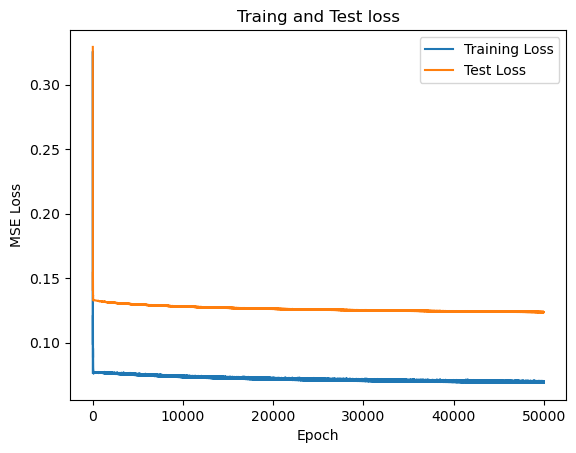

In [113]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label="Training Loss")
plt.plot(test_losses,label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
#plt.yscale("log")
plt.title("Traing and Test loss")
plt.legend()
plt.show()

torch.Size([1225])


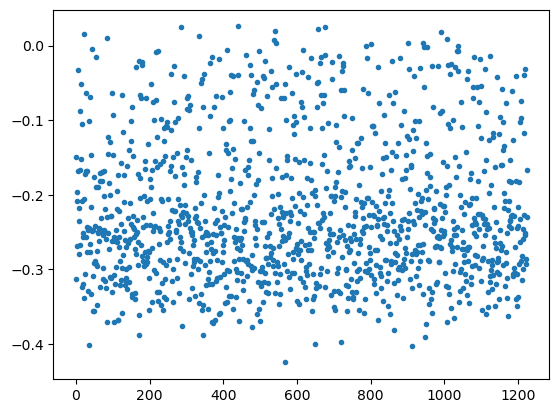

In [116]:
print(mlp2.b_in.shape)
plt.plot(mlp2.b_in.cpu().detach().numpy(),".")